In [ ]:
import Pkg 
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [2]:
using Test
include(joinpath(@__DIR__,"utils/controller.jl"))
include(joinpath(@__DIR__,"utils/animation.jl"))
include(joinpath(@__DIR__,"utils/params.jl"))

(μ = [-2.0, -2.0], k = [0.2, 0.2], τ = 1.0, γ = 10.0, p = 100.0)

## Test nominal controller vs STC controller with TH based CLB in Scenario 1
1 leading HDV ahead of our controlled CAV, and 2 following HDV.
Initially the states of all vehicles are at equilibrium points(v=$v^{\star}$, s=$s^{\star}$).  
The leading HDV suddenly brakes at time t=1.0s with acc=6.0$m^2/s$ for 3.3s, then it speeds up with same acc, back to equilibrium speed $v^{\star}$.    


In [3]:
#test parameter set same with that in the paper
params = (a = HDVs_params.a, b = HDVs_params.b, s_star = all_vehicle_params.s_star, v_max = HDVs_params.v_max,
            s_st = HDVs_params.h_st, s_go = HDVs_params.h_go, v_star = all_vehicle_params.v_star,
            μ = CAV_params.μ, k = CAV_params.k, u_max = all_vehicle_params.a_max, u_min = all_vehicle_params.a_min,
            τ = CAV_params.τ, γ = CAV_params.γ, p = CAV_params.p, car_length = car_params.l)

(a = 0.6, b = 0.9, s_star = 20.0, v_max = 40.0, s_st = 5.0, s_go = 35.0, v_star = 20.0, μ = [-2.0, -2.0], k = [0.2, 0.2], u_max = 7.0, u_min = -7.0, τ = 1.0, γ = 10.0, p = 100.0, car_length = 4.665)

In [4]:
a_H = 6.0
t_H = 3.3
t_brake = 0.5
t_acc = 0.5 + t_H
steady_speed = params.s_star
r(params_, t_) = r_brake_acc(params_, t_, steady_speed, a_H, t_brake, t_acc) - steady_speed

r (generic function with 1 method)

In [5]:
function pos_integral(params::NamedTuple, p::Float64, r, t0::Float64, dt::Float64)
    v_star = params.v_star
    k1 = dt*(r(params, t0)+v_star)
    k2 = dt*(r(params, t0+dt/2)+v_star)
    k3 = dt*(r(params, t0+dt)+v_star)
    p + (1/6)*(k1 + 4*k2 + k3)
end

pos_integral (generic function with 1 method)

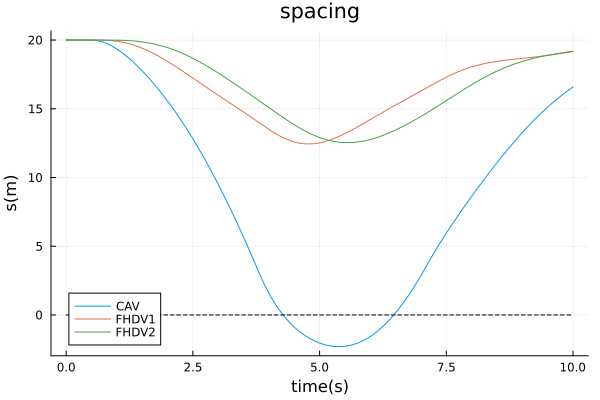

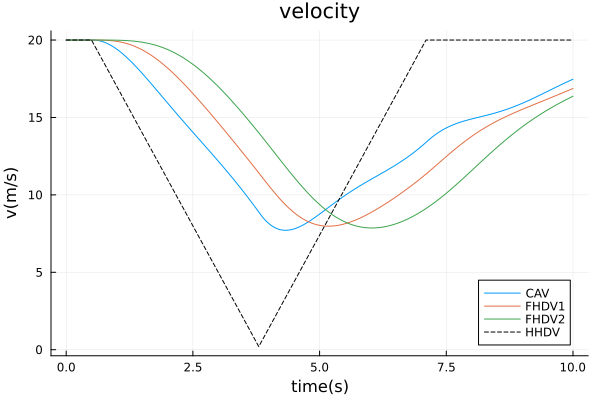

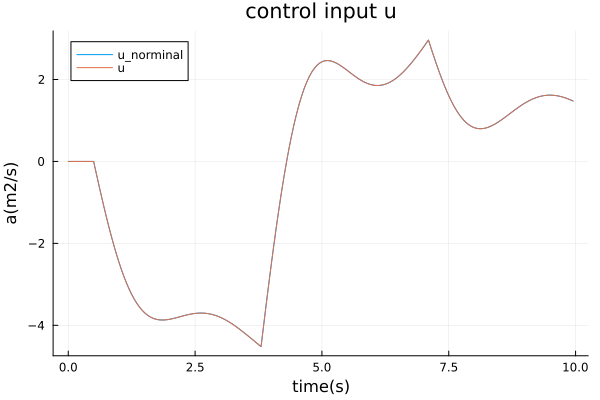

nominal controller: Test Failed at In[6]:61
  Expression: collision_step == 0
   Evaluated: 87 == 0
Stacktrace:
 [1] macro expansion
   @ In[6]:61 [inlined]
 [2] macro expansion
   @ /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[6]:2
Test Summary:      | Fail  Total
nominal controller |    1      1


LoadError: [91mSome tests did not pass: 0 passed, 1 failed, 0 errored, 0 broken.[39m

In [6]:
@testset "nominal controller" begin 
    nx = 6
    x0 = zeros(nx) # deviation from eq-points
    
    # simulation size 
    dt = 0.05
    tf = 10.0 
    t_vec = 0:dt:tf
    t = 0.0
    N = length(t_vec)
    P_LHDV = zeros(N)
    X = [zeros(nx) for i = 1:N]
    X[1] = x0
    v0 = zeros(N)
    U = [zeros(2) for i = 1:(N-1)]
    collision_step = 0
    for i=1:N-1
        v0[i] = r(params, t)
        y = naive_observer(X[i])
        u_nominal = nominal_controller(params, y, r, t)
        u = min(max(u_nominal, params.u_min), params.u_max) # min and max thrust limitation
        U[i] .= [u_nominal; u]
        X[i+1] = rk4(string_dynamics_, params, X[i], u, r, t, dt)
        if minimum(X[i+1]) ≤ -params.s_star && collision_step == 0
            collision_step = i+1
        end
        P_LHDV[i+1] = pos_integral(params, P_LHDV[i], r, t, dt)
        t += dt
    end
    v0[end] = r(params, t)
    Xm = hcat(X...)
    Um = hcat(U...)
    v_ref = v0 .+ params.v_star
    X_spacing = Xm'[:, [1, 3, 5]] .+ params.s_star
    X_velocity = Xm'[:, [2, 4, 6]] .+ params.v_star
    plot(t_vec,X_spacing,title = "spacing",
        xlabel = "time(s)", ylabel = "s(m)",
        label = ["CAV" "FHDV1" "FHDV2"])
    display(plot!(t_vec,0*t_vec,linestyle = :dash, color = :black,label = ""))
    savefig("simulation/nominal_spacing.png")
    plot(t_vec,X_velocity,title = "velocity",
        xlabel = "time(s)", ylabel = "v(m/s)",
        label = ["CAV" "FHDV1" "FHDV2"])
    display(plot!(t_vec,v_ref,linestyle = :dash, color = :black,label = "HHDV"))
    savefig("simulation/nominal_velocity.png")
    display(plot(t_vec[1:(end-1)],Um',title = "control input u", xlabel = "time(s)", ylabel = "a(m2/s)",
            label = ["u_norminal" "u"]))
    savefig("simulation/nominal_input.png")
    
    #visualize
    P_CAV = P_LHDV - X_spacing[:,1] .- params.car_length
    P_HV1 = P_CAV - X_spacing[:,2] .- params.car_length
    P_HV2 = P_HV1 - X_spacing[:,3] .- params.car_length
    if collision_step > 0
        P_LHDV = P_LHDV[1:collision_step]
        P_CAV = P_CAV[1:collision_step]
        P_HV1 = P_HV1[1:collision_step]
        P_HV2 = P_HV2[1:collision_step]
    end
    # display(animate_traffic_flow(2, P_CAV, [P_HV1, P_HV2], P_LHDV, dt))
    @test collision_step == 0 # collision should be avoided, but in this setting, nomimal controller failed.
end

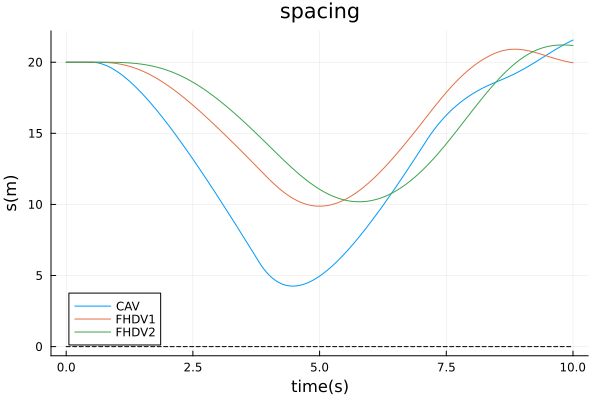

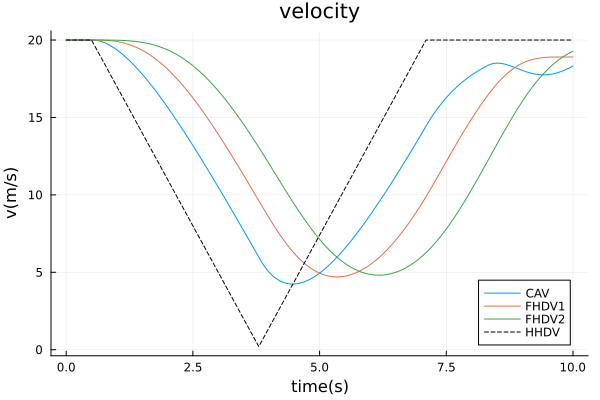

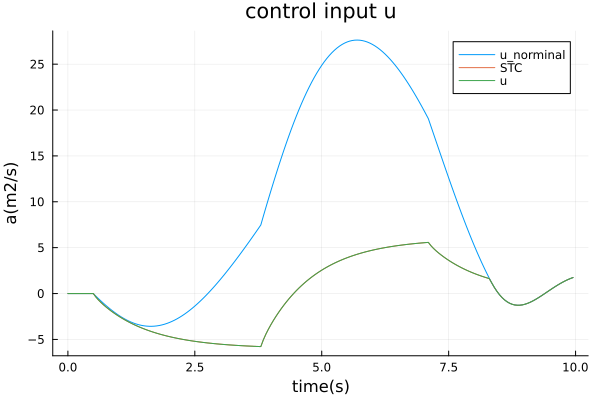

Test Summary:  | Pass  Total
STC controller |    1      1


Test.DefaultTestSet("STC controller", Any[], 1, false, false)

In [7]:
@testset "STC controller" begin 
    nx = 6
    x0 = zeros(nx) # deviation from eq-points
    
    # simulation size 
    dt = 0.05
    tf = 10.0 
    t_vec = 0:dt:tf
    t = 0.0
    N = length(t_vec)
    P_LHDV = zeros(N)
    X = [zeros(nx) for i = 1:N]
    X[1] = x0
    v0 = zeros(N)
    U = [zeros(3) for i = 1:(N-1)]
    collision_step = 0
    for i=1:N-1
        v0[i] = r(params, t)
        y = naive_observer(X[i])
        u_nominal = nominal_controller(params, y, r, t)
        u_STC, _ = CLB_controller(string_dynamics, CLB_TH, CLB_TH_derivative, params, y, u_nominal, r, t)
        u = min(max(u_STC, params.u_min), params.u_max)
        U[i] .= [u_nominal; u_STC; u]
        X[i+1] = rk4(string_dynamics_, params, X[i], u, r, t, dt)
        if minimum(X[i+1]) ≤ -params.s_star && collision_step == 0
            collision_step = i+1
        end
        P_LHDV[i+1] = pos_integral(params, P_LHDV[i], r, t, dt)
        t += dt
    end
    v0[end] = r(params, t)
    Xm = hcat(X...)
    Um = hcat(U...)
    v_ref = v0 .+ params.v_star
    X_spacing = Xm'[:, [1, 3, 5]] .+ params.s_star
    X_velocity = Xm'[:, [2, 4, 6]] .+ params.v_star
    plot(t_vec,X_spacing,title = "spacing",
        xlabel = "time(s)", ylabel = "s(m)",
        label = ["CAV" "FHDV1" "FHDV2"])
    display(plot!(t_vec,0*t_vec,linestyle = :dash, color = :black,label = ""))
    savefig("simulation/STC_spacing.png")
    plot(t_vec,X_velocity,title = "velocity",
        xlabel = "time(s)", ylabel = "v(m/s)",
        label = ["CAV" "FHDV1" "FHDV2"])
    display(plot!(t_vec,v_ref,linestyle = :dash, color = :black,label = "HHDV"))
    savefig("simulation/STC_velocity.png")
    display(plot(t_vec[1:(end-1)],Um',title = "control input u", xlabel = "time(s)", ylabel = "a(m2/s)",
            label = ["u_norminal" "STC" "u"]))
    savefig("simulation/STC_input.png")

    #visualize
    P_CAV = P_LHDV - X_spacing[:,1] .- params.car_length
    P_HV1 = P_CAV - X_spacing[:,2] .- params.car_length
    P_HV2 = P_HV1 - X_spacing[:,3] .- params.car_length
    if collision_step > 0
        P_LHDV = P_LHDV[1:collision_step]
        P_CAV = P_CAV[1:collision_step]
        P_HV1 = P_HV1[1:collision_step]
        P_HV2 = P_HV2[1:collision_step]
    end
    # display(animate_traffic_flow(2, P_CAV, [P_HV1, P_HV2], P_LHDV, dt))
    @test collision_step == 0 # collision should be avoided, STC controller suceeded.
end